## Import libraries

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

from pandas.api.types import CategoricalDtype

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/usr/local/python/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


## Download data

In [2]:
aoi_dir = f'../../data/external/temporal_todocker/arroyo_vivo/cuenca_arroyo_32614.gpkg'
pois_dir = f'../../data/external/temporal_todocker/arroyo_vivo/residuos_arroyovivo_v3_encuenca_32614.gpkg'

<Axes: >

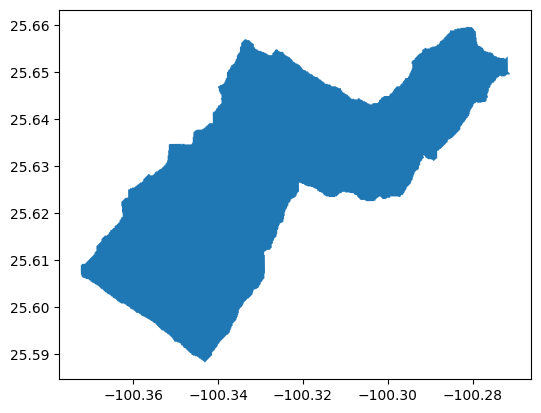

In [3]:
aoi = gpd.read_file(aoi_dir)
aoi = aoi.to_crs("EPSG:4326")

# Show
aoi.plot()

In [4]:
pois = gpd.read_file(pois_dir)
pois = pois.to_crs("EPSG:4326")

# Show
print(pois.shape)
pois.head(1)

(16179, 9)


,itemname,tipo,material,quantity,latitude,longitude,altitude,data_origin,geometry
0,Latas de aluminio o estaño,NaN,Aluminio,11,25.644154,-100.310618,627.104902,9 de enero.csv,MULTIPOINT (-100.31062 25.64415)


## Create hexgrid

In [5]:
resolution = 10

(1890, 2)


<Axes: >

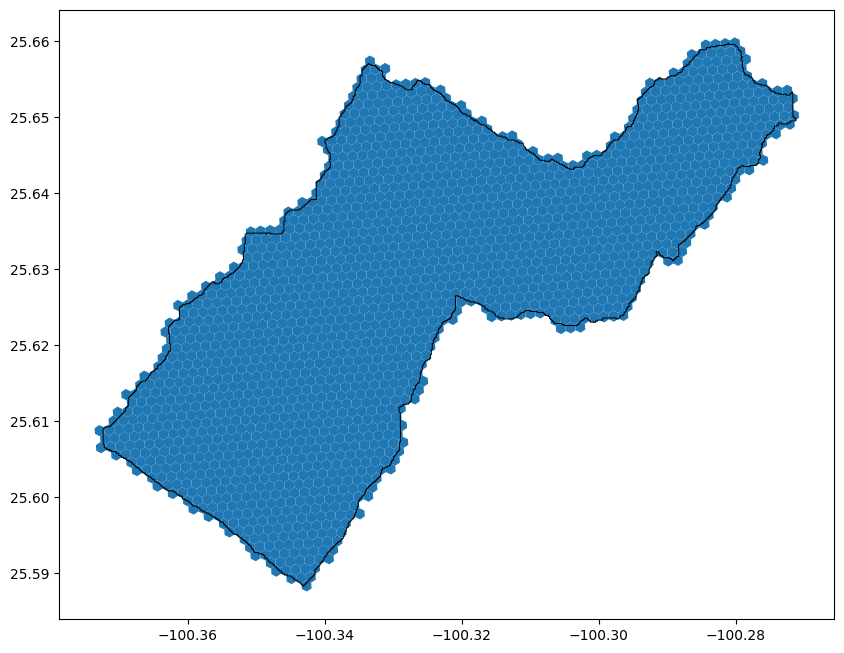

In [6]:
# Create buffer for aoi in order to create a hexgrid that includes all the area
aoi_buffer = aoi.to_crs("EPSG:6372").buffer(60)
aoi_buffer = aoi_buffer.to_crs("EPSG:4326")
aoi_buffer = gpd.GeoDataFrame(geometry=aoi_buffer).dissolve()

# Go back to EPSG:4326
aoi = aoi.to_crs("EPSG:4326")

# Create hexgrid
hexgrid = aup.create_hexgrid(aoi_buffer,resolution)

# Show
print(hexgrid.shape)

fig,ax = plt.subplots(figsize=(10,10))
hexgrid.plot(ax=ax,zorder=1)
aoi.plot(ax=ax, zorder=2, facecolor="none", edgecolor='black', lw=0.7)

## Group data by hex

In [7]:
materiales_list = list(pois.material.unique())

In [8]:
summary = hexgrid.copy()

pois_copy = pois.copy()
pois_copy.loc[:,'count'] = 1

for material in materiales_list:
    pois_process = pois_copy.loc[pois.material == material]
    pois_inhex = gpd.sjoin(pois_process, hexgrid)
    
    # Sum by hex count (individual points) and quantity (how much trash was registered in that point)
    groupby = pois_inhex.groupby(f'hex_id_{resolution}').agg({'count':np.sum,
                                                              'quantity':np.sum})
    
    groupby.rename(columns={'count':material,
                            'quantity':f'{material}_quantity'},inplace=True)
    groupby = groupby[[material,f'{material}_quantity']]
    
    # Join groupby
    summary = pd.merge(summary,groupby, on=f'hex_id_{resolution}',how='outer')

# Format -----------------------------------------------
# Delete NaNs
summary = summary.fillna(0)

# Sum total garbage points by hex
summary['total'] = summary[materiales_list].sum(axis=1)

# Sum total garbage quantity by hex
materiales_quantity_list = []
for material in materiales_list:
    column_name = f'{material}_quantity'
    materiales_quantity_list.append(column_name)
summary['total_quantity'] = summary[materiales_quantity_list].sum(axis=1)

# Delete hexs without data
idx = summary['total'] != 0
summary_f = summary.loc[idx]
#Sort values 
summary_f = summary_f.sort_values(by='total',ascending=False)

# Show -----------------------------------------------
print(summary_f.shape)
summary_f.head(2)

(142, 48)


,hex_id_10,geometry,Aluminio,Aluminio_quantity,Baterias,Baterias_quantity,Carton,Carton_quantity,Cenizas,Cenizas_quantity,...,Tela,Tela_quantity,Unicel,Unicel_quantity,Vidrio,Vidrio_quantity,EPI,EPI_quantity,total,total_quantity
804,8a48a20296a7fff,"POLYGON ((-100.30269 25.63956, -100.30201 25.6...",13.0,24.0,0.0,0.0,36.0,44.0,0.0,0.0,...,84.0,108.0,207.0,259.0,89.0,137.0,1.0,1.0,1918.0,2669.0
1367,8a48a202978ffff,"POLYGON ((-100.30331 25.63839, -100.30263 25.6...",10.0,33.0,0.0,0.0,13.0,15.0,2.0,2.0,...,81.0,170.0,57.0,238.0,26.0,55.0,0.0,0.0,1122.0,2473.0


## Review output

In [9]:
# Check result
print(f'Original total: {pois.shape[0]}')
print(f'total after groupby: {summary_f.total.sum()}')

print(f'Original total quantity: {pois.quantity.sum()}')
print(f'total quantity after groupby: {summary_f.total_quantity.sum()}')

Original total: 16179
total after groupby: 16179.0
Original total quantity: 30692
total quantity after groupby: 30692.0


<Axes: >

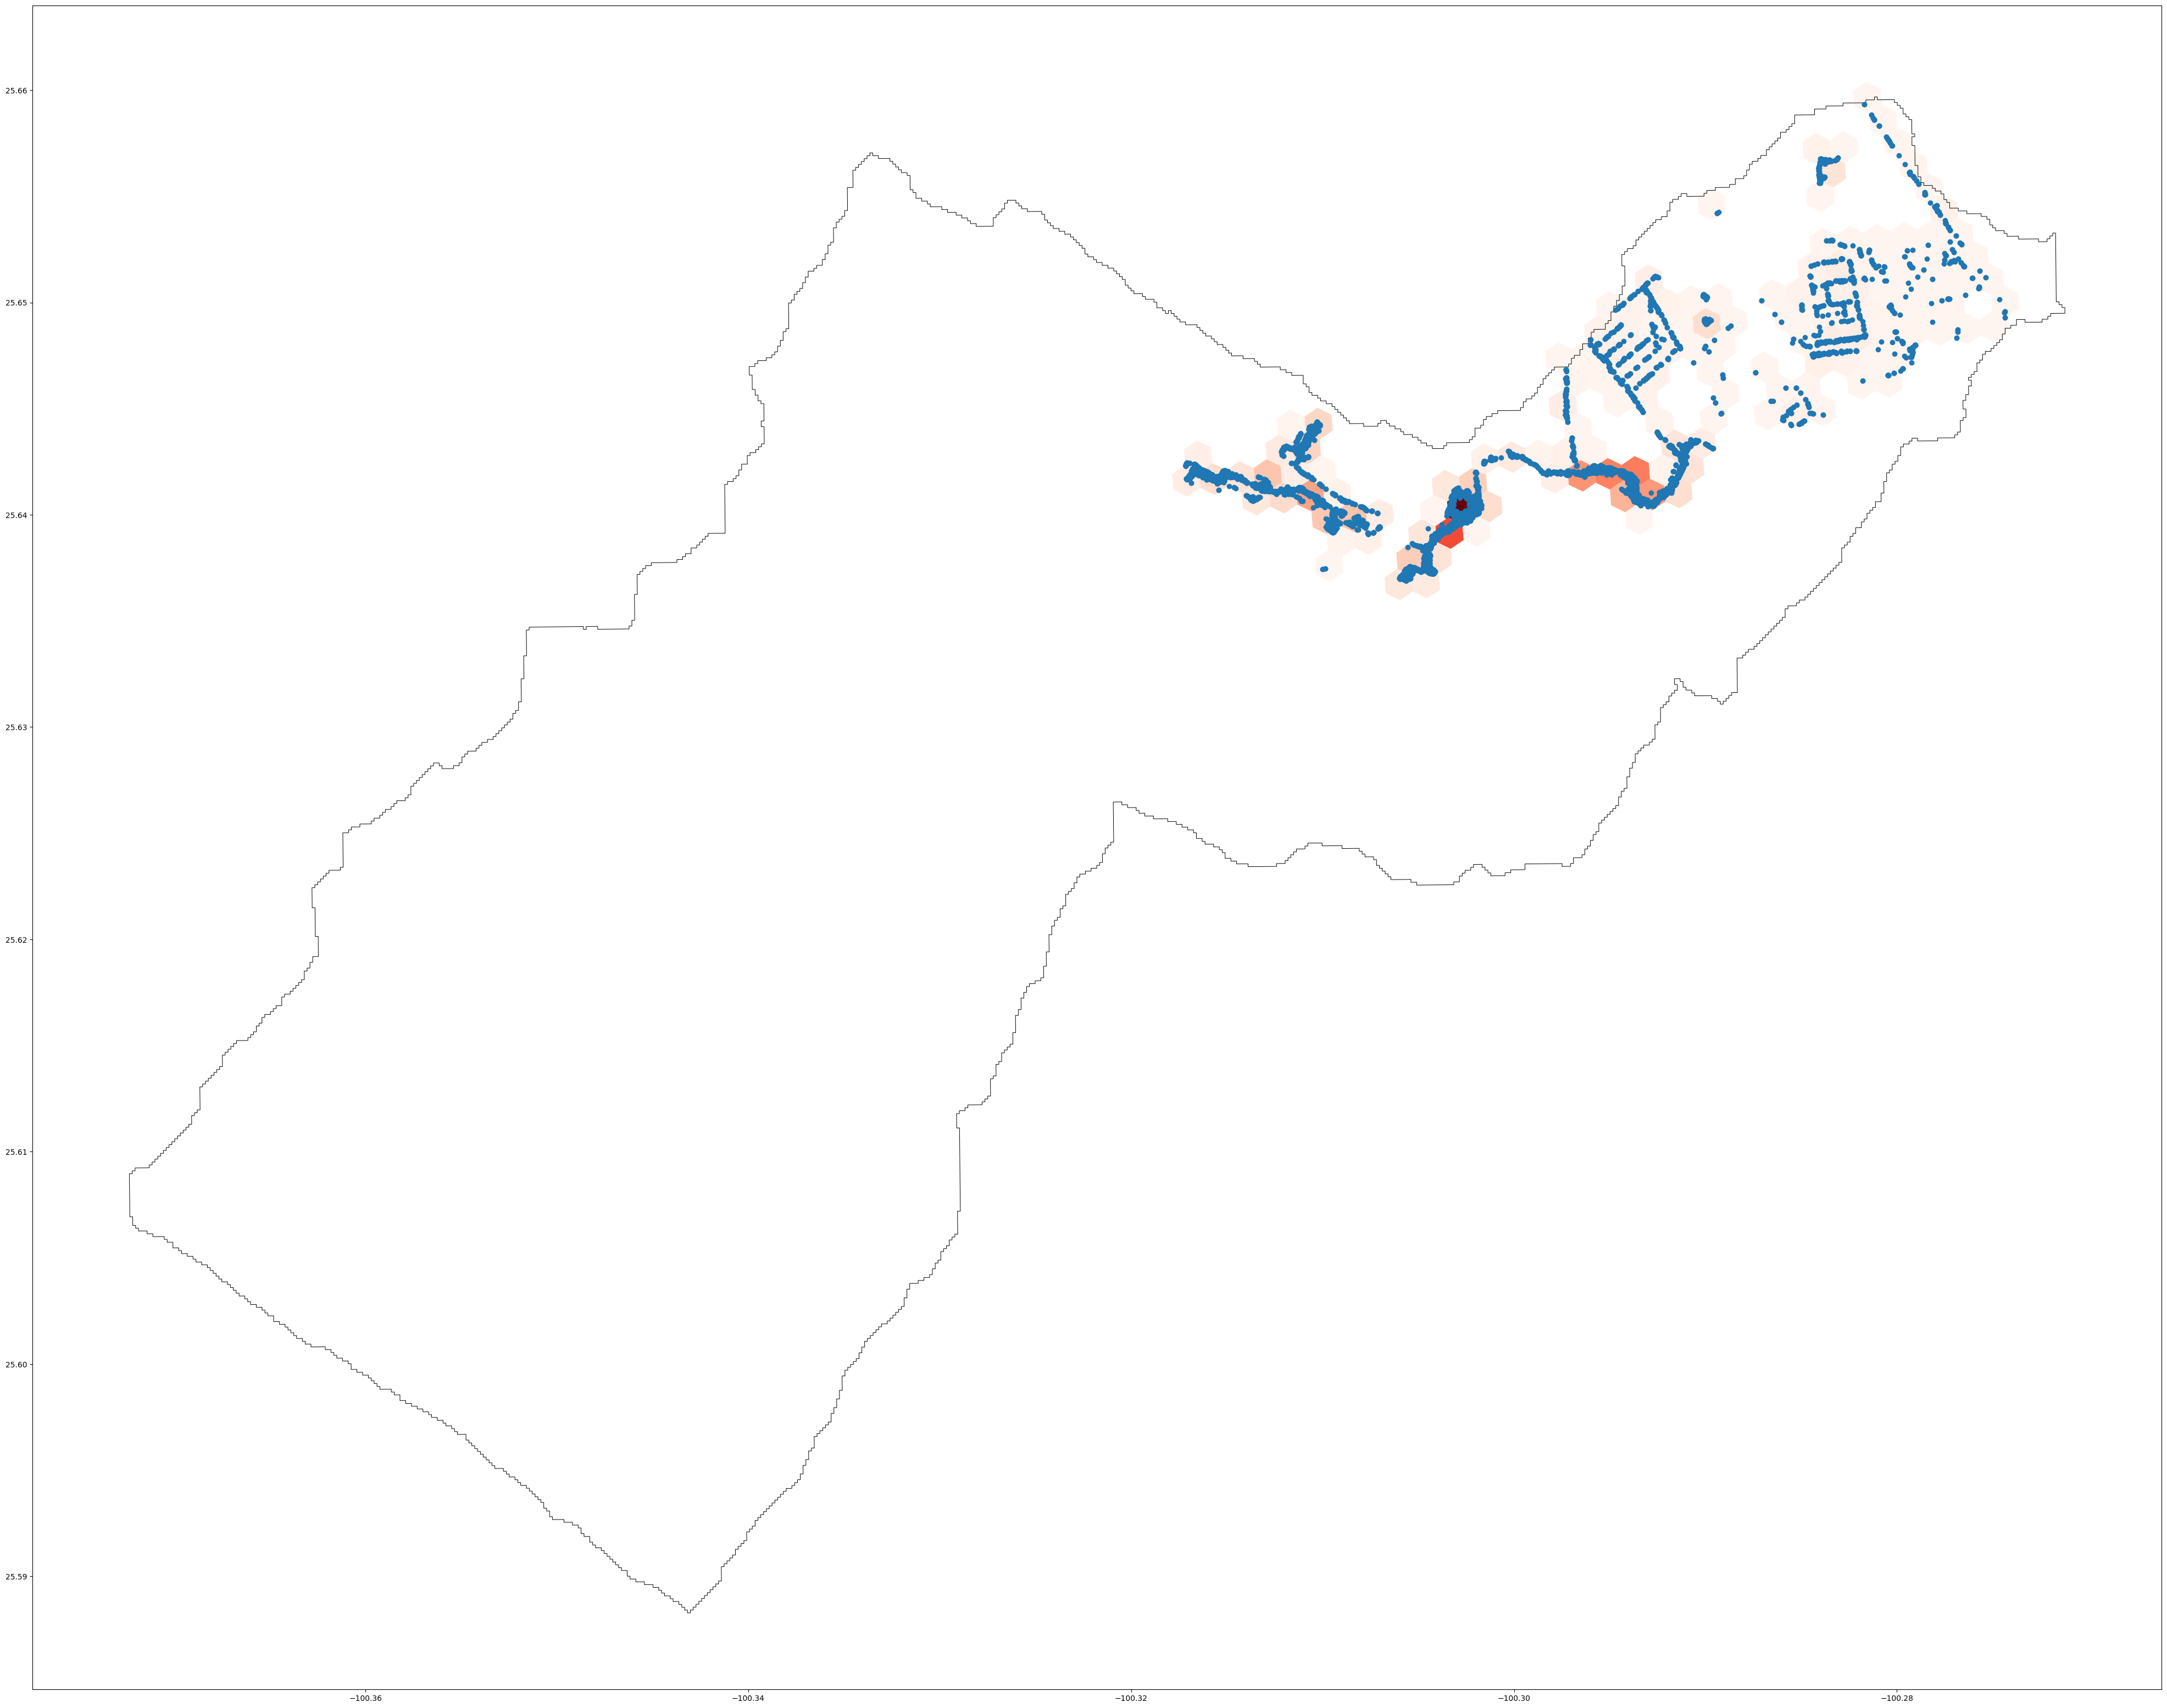

In [10]:
fig,ax = plt.subplots(figsize=(50,50))

summary_f.plot('total', cmap='Reds',ax=ax,zorder=0)
aoi.plot(ax=ax, zorder=1, facecolor="none", edgecolor='black', lw=0.7)
pois.plot(ax=ax, zorder=2)

## Save output

In [11]:
summary_f.to_file(f'../../data/external/temporal_fromjupyter/arroyo_vivo/residuosarroyo_hexres10.gpkg')